<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/work_from_here/nifty_usd_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pykalman -q
#!-----> USD

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime
from pykalman import KalmanFilter

In [30]:
data=pd.read_csv('/content/usd.csv')

In [31]:
data.head(2)

,time,open,high,low,close,"USDINR, ICE: Open","USDINR, ICE: High","USDINR, ICE: Low","USDINR, ICE: Close",Volume,Volume MA
0,1357184700,6058.15,6058.15,6026.6,6039.55,54.348,54.600,54.178,54.48,5260800,9113150.0
1,1357271100,6031.05,6052.50,6012.5,6048.00,54.455,55.173,54.448,54.93,6106100,8723720.0


In [32]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [33]:
del data['time']

In [34]:
data= data.set_index('date')

In [35]:
data.head(2)

,open,high,low,close,"USDINR, ICE: Open","USDINR, ICE: High","USDINR, ICE: Low","USDINR, ICE: Close",Volume,Volume MA
date,,,,,,,,,,
03-01-2013,6058.15,6058.15,6026.6,6039.55,54.348,54.600,54.178,54.48,5260800,9113150.0
04-01-2013,6031.05,6052.50,6012.5,6048.00,54.455,55.173,54.448,54.93,6106100,8723720.0


In [36]:
data=data['27-10-2016':]

In [37]:
data_subset=data[['close','USDINR, ICE: Close']]

In [38]:
data_subset.columns=['close','close1']

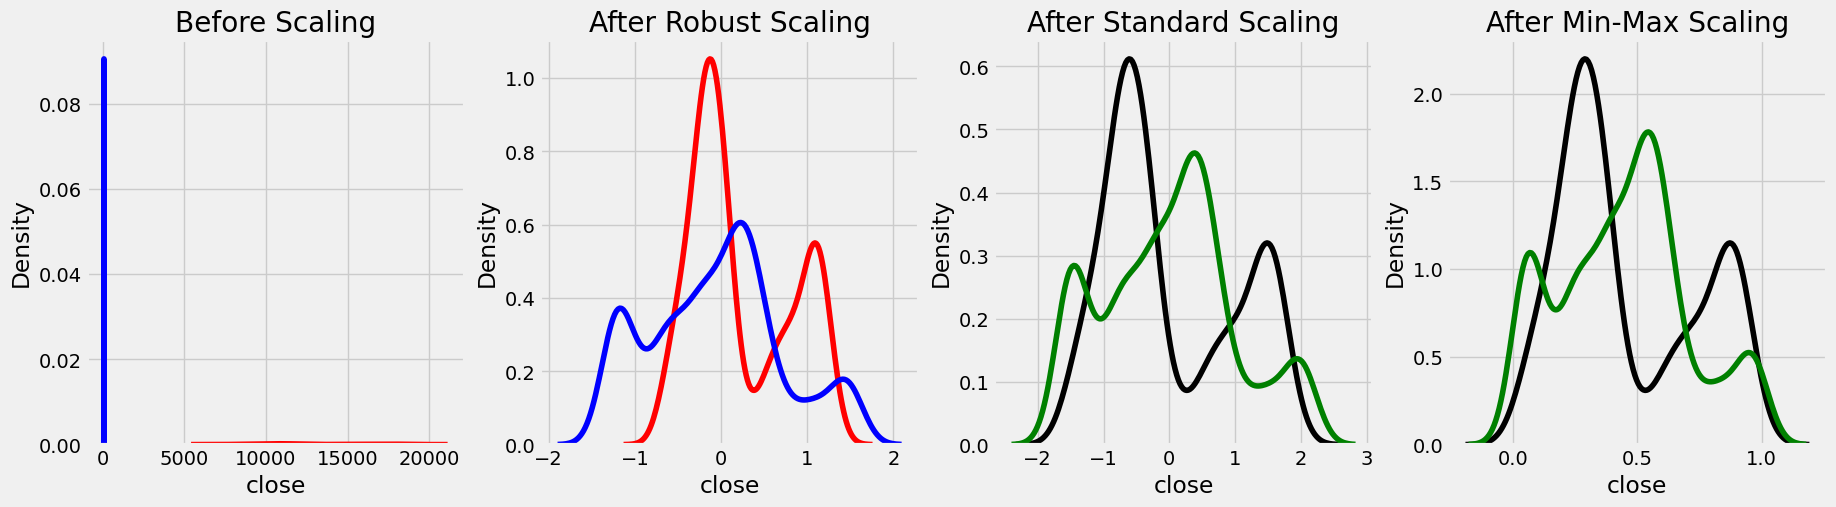

In [39]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


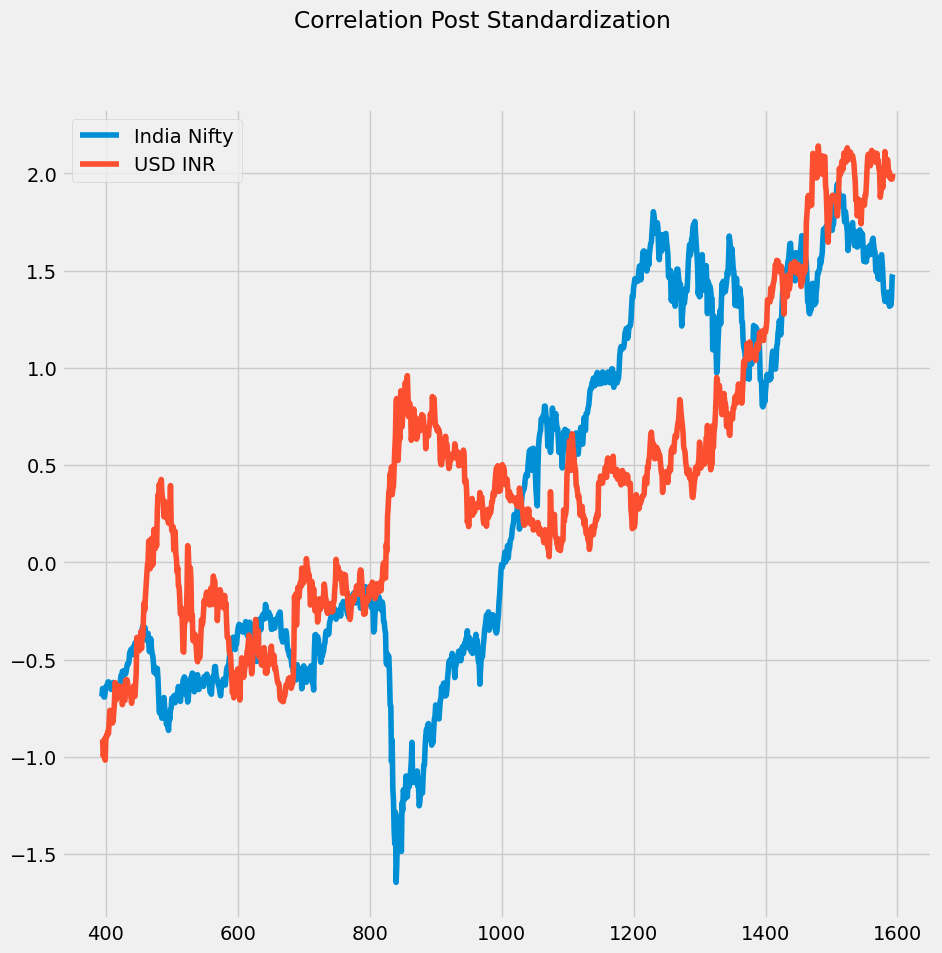

In [40]:
columns=['India Nifty','USD INR']
standard_df=standard_df.fillna(method='ffill')
standard_df.columns=columns
standard_df[-1200:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

In [55]:
standard_df['diff']=standard_df['India Nifty']-standard_df['USD INR']*.53
standard_df['mov_avg']=standard_df['diff'].ewm(span=35).mean()

In [56]:
standard_df['spread']= np.sign(standard_df['mov_avg'].diff())

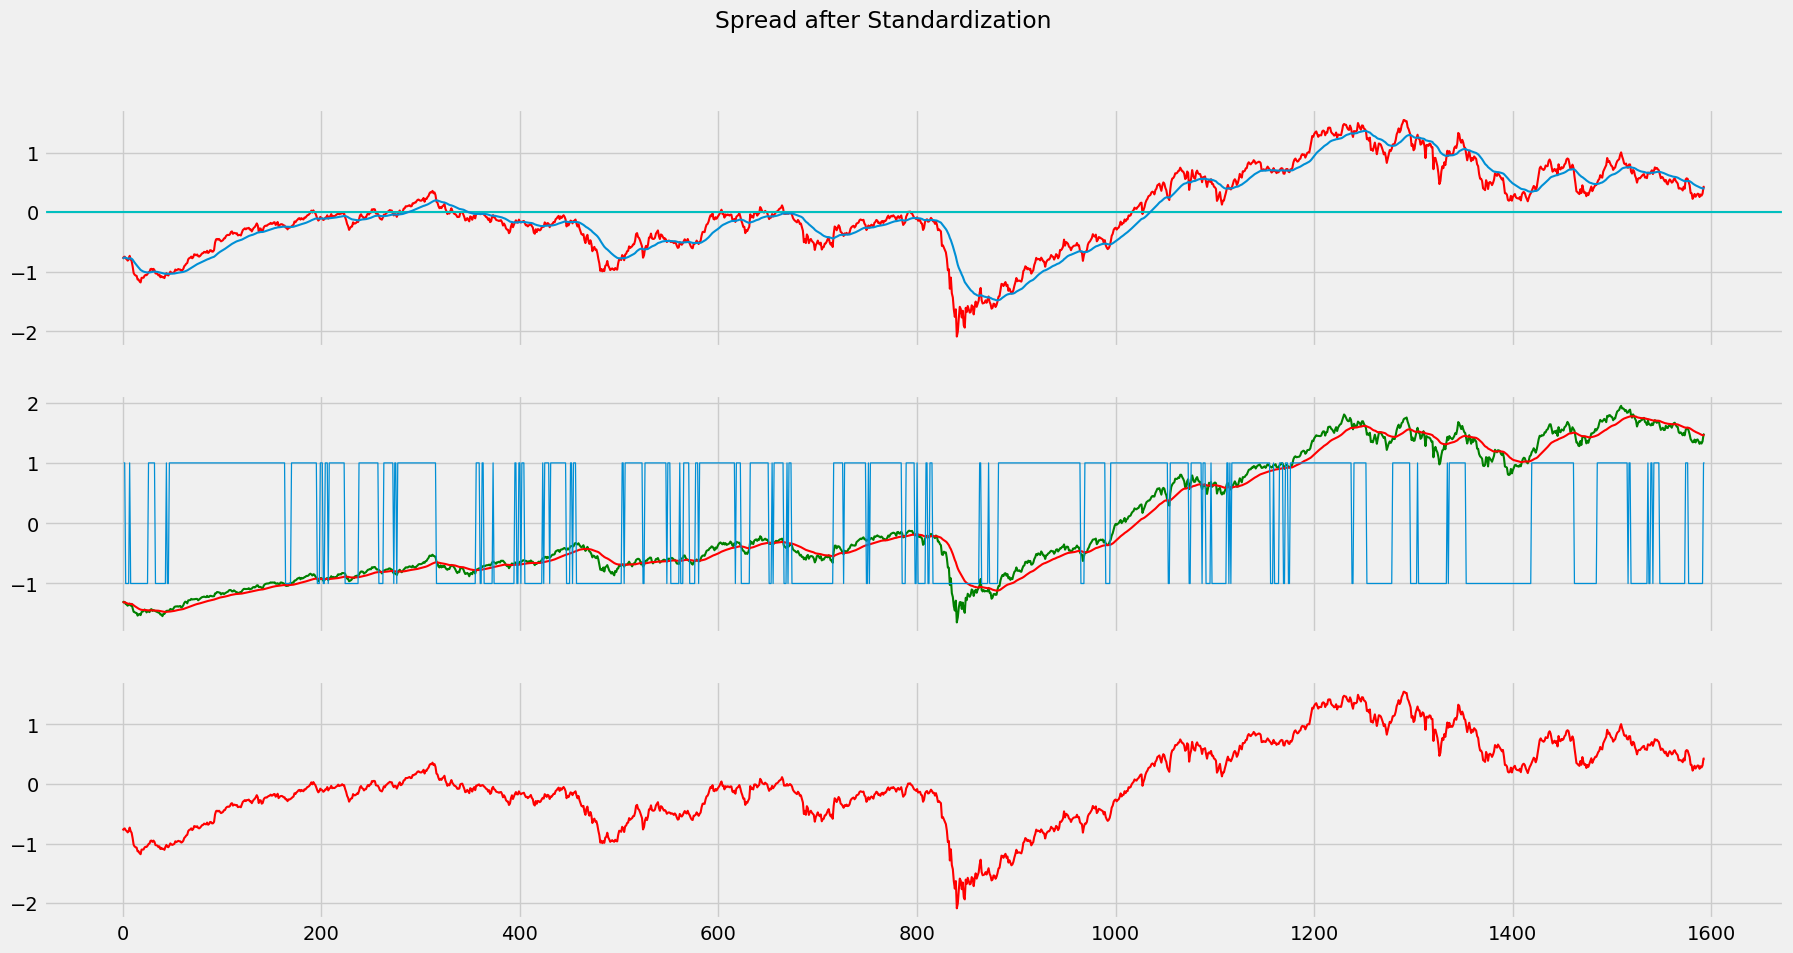

In [57]:
standard_df['India_Nifty_mov']=standard_df['India Nifty'].ewm(span=35).mean()
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(3,1,sharex=True)
ax[0].plot(standard_df['diff'],color='r',lw=1.5)
ax[2].plot(standard_df['diff'],color='r',lw=1.5)
ax[1].plot(standard_df['India Nifty'],color='g',lw=1.5)
ax[1].plot(standard_df['India_Nifty_mov'],color='r',lw=1.5)
ax[0].axhline(y=0,color='c',lw=1.5)
ax[1].plot(standard_df['spread'],lw=0.9)
#ax[0].axhline(y=-3,color='g')
plt.suptitle('Spread after Standardization')
ax[0].plot(standard_df['mov_avg'],lw=1.5)
plt.show()



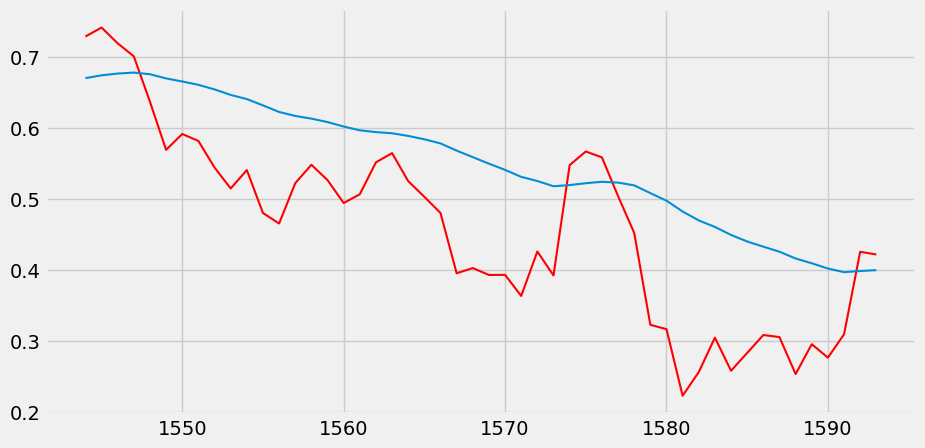

In [58]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(standard_df['diff'][-50:],color='r',lw=1.5)
plt.plot(standard_df['mov_avg'][-50:],lw=1.5);

In [59]:
df = standard_df[['diff']]

mean 0.5854202827998605


Text(0.5, 0, 'Days')

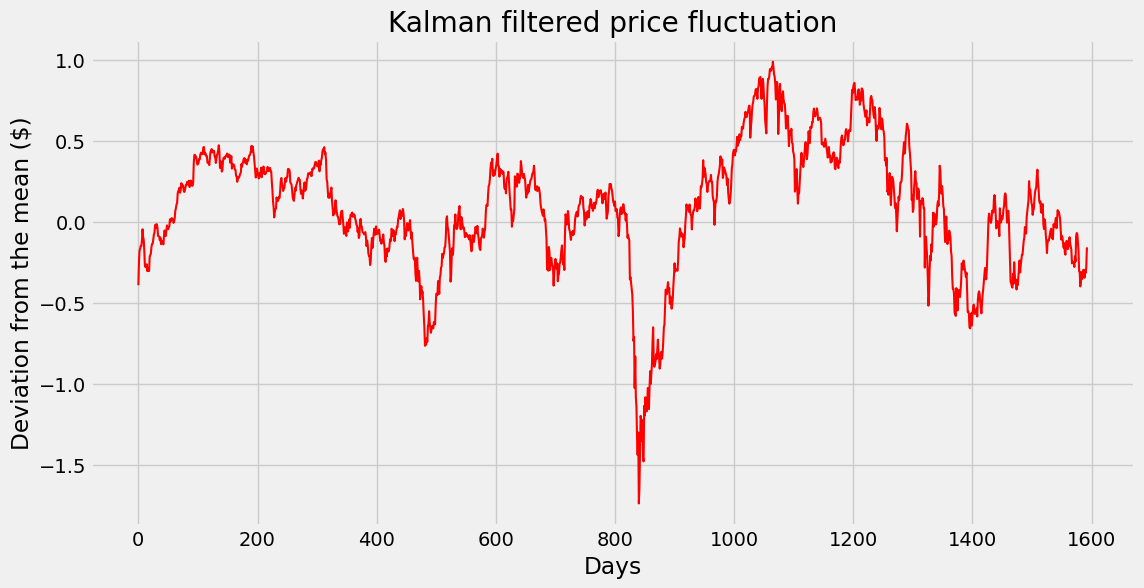

In [60]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['diff'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['diff'].values - mean, 'red', lw=1.5)


plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [61]:
spread= pd.DataFrame({'Date':df.index,'spread':(df['diff'].values - mean)})

In [62]:
spread=spread.set_index('Date')

In [63]:
df_new=pd.concat([df,spread['spread']],axis=1)

In [64]:
df_new['30 Day MA'] = df_new['spread'].ewm(span=50).mean()


In [65]:
df_new['signal'] = np.where((df_new['30 Day MA']>=df_new['spread']),-1,1)

In [66]:

# set .std(ddof=0) for population std instead of sample
df_new['30 Day STD'] = df_new['spread'].rolling(window=50).std() 
df_new['Upper Band'] = df_new['30 Day MA'] + (df_new['30 Day STD'] *1.5)
df_new['Lower Band'] = df_new['30 Day MA'] - (df_new['30 Day STD'] *1.5)
df_new['boll_percent'] = (df_new['spread']-df_new['Lower Band'])/(df_new['Upper Band']-df_new['Lower Band'])

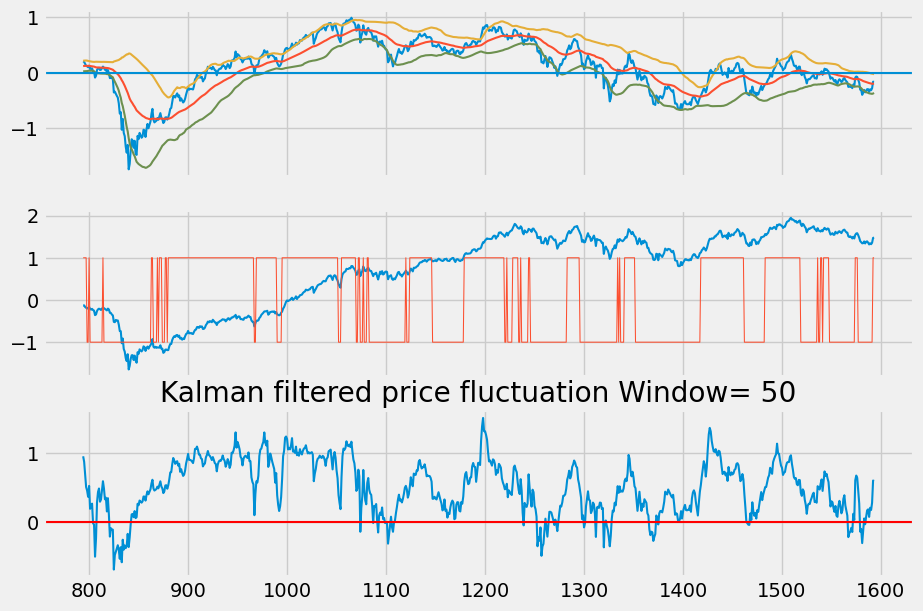

In [67]:
fig, ax = plt.subplots(3,1,figsize=(10,7),sharex=True)
#plt.plot(df_new['Adj Close'].values - mean, 'red', lw=1.5)
ax[0].plot(df_new[['spread','30 Day MA','Upper Band','Lower Band']][-800:],lw=1.5)
ax[0].axhline(y=0,lw=1.5)
#plt.axhline(y=1000)
#plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation Window= 50")
#ax[0].ylabel("Deviation from the mean ($)")
#ax[0].xlabel("Days")
ax[2].plot(df_new[['boll_percent']][-800:],lw=1.5)
ax[2].axhline(y=0,color='r',lw=1.5)
ax[1].plot(standard_df[['India Nifty']][-800:],lw=1.5)
ax[1].plot(df_new[['signal']][-800:],lw=0.75)
plt.show()

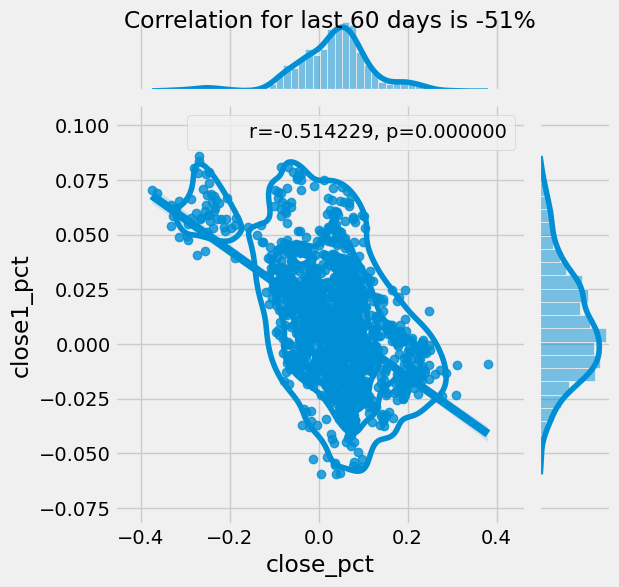

In [68]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()